In [1]:

import sys
sys.path.append('../scratch_2')
from common.np import *
from common.layers import Embedding, SigmoidWithLoss
import collections 

import numpy as np

### Embedding 계층의 구현

입력층과 은닉층 사이의 가중치과 입력값의 Matmul의 결과는 가중치 행렬의 row vector를 끄집어 내는것과 같은 일을 하므로 행렬곱으로 표현하지 않고, 행렬의 일부를 가지고 오는 slicing, indexing을 이용할 수 있다.

In [2]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]            # MatMul 연산에서 바뀜
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0

        # dW[self.idx] = dout
        # 이렇게 하면 배열의 원소중 값이 값은 원소가 있다면 할당시 문제가 생김.
        # 따라서 할당이 아닌 더하기를 해준다.
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        
        return None

Embedding 계층을 이용하면 입력층 계산에서의 낭비를 줄일 수 있다. 남은 문제는 은닉층 이후의 처리이다. 은닉층 이후에서 계산이 오래걸리는 곳은 다음의 두 부분 이다.
* 은닉층의 뉴런과 가중치 행렬(Wout)의 곱
* Softmax계층의 계산
앞서 언급한 두가지는 모두 어휘가 많아지면 계산량이 매우 증가한다.

따라서 Softmax를 대신할 가벼운 계산이 필요한데 이것이 *네거티브 샘플링*이다.

### 네거티브 샘플링 기법

다중분류(multi - classification)을 이진 분류(binary - classification)로 근사하는것이 네거티브 샘플링이다.
* 다중분류는 지금까지 한것과 같이 여러개의 단어 중에서 옳은 단어 하나를 선택하는 것을 말한다.
* 이진 분류는 Yes/No로 대답하는 것과 같은데, 타깃 단어는 say입니까? 와 같은 질문에 답하는 형식이다.

이렇게 하면 충력층에는 뉴런을 하나만 준비하면 된다. 이 뉴런이 점수(얼마나 yes인지)를 출력하는 것이다. 여기서 시그모이드 함수를 통해 확률로 변환한다.(시그모이드 함수는 0부터 1까지의 출력을 갖는데 이를 확률로 해석한다.)

cross entropy error를 loss함수로 사용하는데, cross entropy error와 sigmoid함수의 역전파를 계산하면 출력이 y-t즉 오차가 된다. 이 오차는 앞의 계층으로 흘러가게 된다. 즉, 오차가 크면 크게 학습하고 오차가 작으면 작게 학습한다는 의미이다.

In [8]:
class EmbeddingDot:
    def __init__(self, W): # 가중치 행렬
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx): # 은닉층, 단어 번호
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis = 1)
       
        self.cache = (h, target_W)
        return out
    
    def backward(self,dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout*target_W
        return dh

우리가 EmbeddingDot 계층과 sigmoid계층을 을 통해 원하는 것은 정답일경우 sigmoid의 출력을 1에 가깝게 하고, 오답일 경우 sigmoid의 출력을 0에 가깝게 하는 것이다. 이를 위해서는 정답일경우 순전파의 출력이 크도록, 오답일 경우 순전파의 출력이 작도록 만들어야 한다.

그럼 오답에 대해서도 학습을 진행해야 하는데 이렇게 되면 어휘수가 많아질수록 계산량이 매우 커진다는 같은 문제점을 접하게 된다. 때문에 오답의 일부만 샘플링 하여 학습에 사용할것이다. 이를 negative sampling 이라고 한다.

정리하자면, 정답을 타깃으로 한경우 손실함수를 계산하고, 오답을 타깃으로 한경우 손실함수를 계산하여 이들을 더한것을 최종 손실로 생각한다.

그럼 샘플링 하는 방식이 중요해진다.가장 간단한 방식은 당연히 무작위로 샘플링 하는 것이나, 더 좋은 방법은 말뭉치의 통계 데이터를 활용하는 방법이다. 즉, 말뭉치에 많이 등장하는 단어는 자주 샘플링하고, 적게 등장하는 단어는 적게 샘플링하는 것이다. 이를 위해서는 각 단어의 확률분포를 알아야 한다.

np.random.choice()를 무작위 샘플링 용도로 사용할 수 있다. p에 확률분포를 담은 리스트를 지정하고, replace=False로 설정하면 네거티브 샘플링 용도로 활용 할수 있게 된다. 

하지만 네거티브 샘플링에서는 기본 확률분포에 0.75를 곱하는데 이는 확률분포가 낮은 단어를 버리지 않기 위해서 이다. 0.75제곱을 하면 확률분포가 낮은 단어의 확률을 살짝 높일 수 있다.

In [10]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size): # 말뭉치, 확률분포 변경을 위한 지수, 네거티브 샘플링 시행 횟수
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        # 말뭉치에 포함된 각 단어의 개수 세기
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
        
        # 말뭉치속 단어의 종류 
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        # 확률분포를 표현할 리스트 0으로 초기화
        self.word_p = np.zeros(vocab_size)
        
        # 각 단어의 확률 분포 계산, 낮은 확률의 가지는 단어를 버리지 않기 위해 power 제곱
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target): # target 단어를 긍정적 예로 해석하고 그외의 단어 ID를 샘플링 -> 부적적 샘플링 시행
        batch_size = target.shape[0]
        
        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype = np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy() # 원본 리스트를 건드리지 않음. 똑같이 생긴 다른 리스트를 리턴함
                target_idx = target[i] # 미니배치중 i번째로 받은 단어를 target으로 설정
                p[target_idx] = 0      # target은 뽑히면 안됨.
                p /= p.sum()
                
                negative_sample[i,:] = np.random.choice(self.vocab_size, size = self.sample_size, replace=False, p=p)
        
        else :
            print("GPU - may contain target word")
            # GPU로 계산할때는 속도를 우선하기 위해 target을 포함할수도 있게됨
            
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size), replace = True, p = self.word_p)
        
        return negative_sample

In [6]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size=2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

not GPU
[[4 3]
 [0 2]
 [3 1]]


In [5]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power = 0.75, sample_size = 5):
        self.sample_size = sample_size
        self.sampler  = UnigramSampler(corpus, power, sample_size)
        
        # 부적정예를 다루는 계층 sample_size개  + 긍정적 예를 다루를 계층 1개
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1 )] 
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [],[]
        
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32) # 정답 레이블
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32) # 정답 레이블
        for i in range(self.sample_size):
            negative_target = negative_sample[:,i]                           # i번째 coluumn
            score = self.embed_dot_layers[1 + i].forward(h, negative_target) # 각 계츠의 순전파 호출
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
        
    
    def backward(self, dout = 1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh  += l1.backward(dscore)
            
        return dh
        
        
        
        

### CBOW 모델

In [6]:
import sys
sys.path.append('../from_scratch2')
import numpy as np

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 계층 생성
        self.in_layers = []
        for i in range(2*window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치과 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:,i])
        h *= 1/len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout = 1):
        dout = self.ns_loss.backward(dout)
        dout *= 1/len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

CBOW모델의 학습용 코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.94
| 에폭 1 |  반복 121 / 9295 | 시간 8[s] | 손실 3.79
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.62
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 12[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 13[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 16[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 17[s] | 손실 3.03
| 에폭 1 |  반복 281 / 9295 | 시간 18[s] | 손실 2.95
| 에폭 1 |  반복 301 / 9295 | 시간 20[s] | 손실 2.91
| 에폭 1 |  반복 321 / 9295 | 시간 21[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 22[s] | 손실 2.82
| 에폭 1 |  반복 361 / 9295 | 시간 23[s] | 손실 2.83
| 에폭 1 |  반복 381 / 9295 | 시간 25[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 26[s] | 손실 2.75
| 에폭 1 |  반복 421 / 9295 | 시간 27[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 

| 에폭 1 |  반복 3561 / 9295 | 시간 245[s] | 손실 2.42
| 에폭 1 |  반복 3581 / 9295 | 시간 246[s] | 손실 2.42
| 에폭 1 |  반복 3601 / 9295 | 시간 247[s] | 손실 2.39
| 에폭 1 |  반복 3621 / 9295 | 시간 249[s] | 손실 2.45
| 에폭 1 |  반복 3641 / 9295 | 시간 250[s] | 손실 2.40
| 에폭 1 |  반복 3661 / 9295 | 시간 252[s] | 손실 2.40
| 에폭 1 |  반복 3681 / 9295 | 시간 253[s] | 손실 2.41
| 에폭 1 |  반복 3701 / 9295 | 시간 254[s] | 손실 2.40
| 에폭 1 |  반복 3721 / 9295 | 시간 256[s] | 손실 2.41
| 에폭 1 |  반복 3741 / 9295 | 시간 257[s] | 손실 2.42
| 에폭 1 |  반복 3761 / 9295 | 시간 259[s] | 손실 2.42
| 에폭 1 |  반복 3781 / 9295 | 시간 260[s] | 손실 2.42
| 에폭 1 |  반복 3801 / 9295 | 시간 261[s] | 손실 2.44
| 에폭 1 |  반복 3821 / 9295 | 시간 263[s] | 손실 2.39
| 에폭 1 |  반복 3841 / 9295 | 시간 264[s] | 손실 2.44
| 에폭 1 |  반복 3861 / 9295 | 시간 266[s] | 손실 2.39
| 에폭 1 |  반복 3881 / 9295 | 시간 267[s] | 손실 2.41
| 에폭 1 |  반복 3901 / 9295 | 시간 268[s] | 손실 2.40
| 에폭 1 |  반복 3921 / 9295 | 시간 270[s] | 손실 2.38
| 에폭 1 |  반복 3941 / 9295 | 시간 271[s] | 손실 2.39
| 에폭 1 |  반복 3961 / 9295 | 시간 272[s] | 손실 2.38
| 에폭 1 |  반복 

| 에폭 1 |  반복 7061 / 9295 | 시간 494[s] | 손실 2.28
| 에폭 1 |  반복 7081 / 9295 | 시간 495[s] | 손실 2.28
| 에폭 1 |  반복 7101 / 9295 | 시간 496[s] | 손실 2.26
| 에폭 1 |  반복 7121 / 9295 | 시간 498[s] | 손실 2.27
| 에폭 1 |  반복 7141 / 9295 | 시간 499[s] | 손실 2.33
| 에폭 1 |  반복 7161 / 9295 | 시간 501[s] | 손실 2.29
| 에폭 1 |  반복 7181 / 9295 | 시간 502[s] | 손실 2.26
| 에폭 1 |  반복 7201 / 9295 | 시간 503[s] | 손실 2.26
| 에폭 1 |  반복 7221 / 9295 | 시간 505[s] | 손실 2.24
| 에폭 1 |  반복 7241 / 9295 | 시간 506[s] | 손실 2.27
| 에폭 1 |  반복 7261 / 9295 | 시간 508[s] | 손실 2.28
| 에폭 1 |  반복 7281 / 9295 | 시간 509[s] | 손실 2.28
| 에폭 1 |  반복 7301 / 9295 | 시간 511[s] | 손실 2.28
| 에폭 1 |  반복 7321 / 9295 | 시간 512[s] | 손실 2.33
| 에폭 1 |  반복 7341 / 9295 | 시간 513[s] | 손실 2.27
| 에폭 1 |  반복 7361 / 9295 | 시간 515[s] | 손실 2.30
| 에폭 1 |  반복 7381 / 9295 | 시간 516[s] | 손실 2.24
| 에폭 1 |  반복 7401 / 9295 | 시간 518[s] | 손실 2.25
| 에폭 1 |  반복 7421 / 9295 | 시간 519[s] | 손실 2.29
| 에폭 1 |  반복 7441 / 9295 | 시간 520[s] | 손실 2.26
| 에폭 1 |  반복 7461 / 9295 | 시간 522[s] | 손실 2.27
| 에폭 1 |  반복 

| 에폭 2 |  반복 1281 / 9295 | 시간 737[s] | 손실 2.08
| 에폭 2 |  반복 1301 / 9295 | 시간 738[s] | 손실 2.13
| 에폭 2 |  반복 1321 / 9295 | 시간 740[s] | 손실 2.14
| 에폭 2 |  반복 1341 / 9295 | 시간 741[s] | 손실 2.15
| 에폭 2 |  반복 1361 / 9295 | 시간 742[s] | 손실 2.15
| 에폭 2 |  반복 1381 / 9295 | 시간 744[s] | 손실 2.10
| 에폭 2 |  반복 1401 / 9295 | 시간 745[s] | 손실 2.14
| 에폭 2 |  반복 1421 / 9295 | 시간 746[s] | 손실 2.14
| 에폭 2 |  반복 1441 / 9295 | 시간 748[s] | 손실 2.10
| 에폭 2 |  반복 1461 / 9295 | 시간 749[s] | 손실 2.14
| 에폭 2 |  반복 1481 / 9295 | 시간 750[s] | 손실 2.15
| 에폭 2 |  반복 1501 / 9295 | 시간 751[s] | 손실 2.13
| 에폭 2 |  반복 1521 / 9295 | 시간 753[s] | 손실 2.15
| 에폭 2 |  반복 1541 / 9295 | 시간 754[s] | 손실 2.14
| 에폭 2 |  반복 1561 / 9295 | 시간 755[s] | 손실 2.16
| 에폭 2 |  반복 1581 / 9295 | 시간 757[s] | 손실 2.15
| 에폭 2 |  반복 1601 / 9295 | 시간 758[s] | 손실 2.17
| 에폭 2 |  반복 1621 / 9295 | 시간 759[s] | 손실 2.13
| 에폭 2 |  반복 1641 / 9295 | 시간 761[s] | 손실 2.16
| 에폭 2 |  반복 1661 / 9295 | 시간 762[s] | 손실 2.18
| 에폭 2 |  반복 1681 / 9295 | 시간 763[s] | 손실 2.14
| 에폭 2 |  반복 

| 에폭 2 |  반복 4781 / 9295 | 시간 988[s] | 손실 2.10
| 에폭 2 |  반복 4801 / 9295 | 시간 989[s] | 손실 2.08
| 에폭 2 |  반복 4821 / 9295 | 시간 991[s] | 손실 2.07
| 에폭 2 |  반복 4841 / 9295 | 시간 992[s] | 손실 2.10
| 에폭 2 |  반복 4861 / 9295 | 시간 994[s] | 손실 2.09
| 에폭 2 |  반복 4881 / 9295 | 시간 996[s] | 손실 2.12
| 에폭 2 |  반복 4901 / 9295 | 시간 997[s] | 손실 2.05
| 에폭 2 |  반복 4921 / 9295 | 시간 999[s] | 손실 2.09
| 에폭 2 |  반복 4941 / 9295 | 시간 1000[s] | 손실 2.09
| 에폭 2 |  반복 4961 / 9295 | 시간 1002[s] | 손실 2.11
| 에폭 2 |  반복 4981 / 9295 | 시간 1003[s] | 손실 2.14
| 에폭 2 |  반복 5001 / 9295 | 시간 1005[s] | 손실 2.06
| 에폭 2 |  반복 5021 / 9295 | 시간 1007[s] | 손실 2.07
| 에폭 2 |  반복 5041 / 9295 | 시간 1008[s] | 손실 2.09
| 에폭 2 |  반복 5061 / 9295 | 시간 1010[s] | 손실 2.07
| 에폭 2 |  반복 5081 / 9295 | 시간 1011[s] | 손실 2.07
| 에폭 2 |  반복 5101 / 9295 | 시간 1013[s] | 손실 2.08
| 에폭 2 |  반복 5121 / 9295 | 시간 1014[s] | 손실 2.06
| 에폭 2 |  반복 5141 / 9295 | 시간 1016[s] | 손실 2.05
| 에폭 2 |  반복 5161 / 9295 | 시간 1017[s] | 손실 2.04
| 에폭 2 |  반복 5181 / 9295 | 시간 1018[s] | 손실 2.04


| 에폭 2 |  반복 8201 / 9295 | 시간 1250[s] | 손실 2.05
| 에폭 2 |  반복 8221 / 9295 | 시간 1251[s] | 손실 2.04
| 에폭 2 |  반복 8241 / 9295 | 시간 1253[s] | 손실 1.99
| 에폭 2 |  반복 8261 / 9295 | 시간 1254[s] | 손실 2.01
| 에폭 2 |  반복 8281 / 9295 | 시간 1255[s] | 손실 2.01
| 에폭 2 |  반복 8301 / 9295 | 시간 1257[s] | 손실 2.05
| 에폭 2 |  반복 8321 / 9295 | 시간 1259[s] | 손실 2.03
| 에폭 2 |  반복 8341 / 9295 | 시간 1260[s] | 손실 2.01
| 에폭 2 |  반복 8361 / 9295 | 시간 1262[s] | 손실 2.04
| 에폭 2 |  반복 8381 / 9295 | 시간 1263[s] | 손실 2.02
| 에폭 2 |  반복 8401 / 9295 | 시간 1265[s] | 손실 2.02
| 에폭 2 |  반복 8421 / 9295 | 시간 1266[s] | 손실 1.98
| 에폭 2 |  반복 8441 / 9295 | 시간 1268[s] | 손실 2.00
| 에폭 2 |  반복 8461 / 9295 | 시간 1269[s] | 손실 2.00
| 에폭 2 |  반복 8481 / 9295 | 시간 1271[s] | 손실 2.03
| 에폭 2 |  반복 8501 / 9295 | 시간 1273[s] | 손실 2.02
| 에폭 2 |  반복 8521 / 9295 | 시간 1274[s] | 손실 2.02
| 에폭 2 |  반복 8541 / 9295 | 시간 1276[s] | 손실 1.99
| 에폭 2 |  반복 8561 / 9295 | 시간 1277[s] | 손실 2.05
| 에폭 2 |  반복 8581 / 9295 | 시간 1279[s] | 손실 2.01
| 에폭 2 |  반복 8601 / 9295 | 시간 1280[s] | 

| 에폭 3 |  반복 2341 / 9295 | 시간 1514[s] | 손실 1.92
| 에폭 3 |  반복 2361 / 9295 | 시간 1515[s] | 손실 1.94
| 에폭 3 |  반복 2381 / 9295 | 시간 1517[s] | 손실 1.93
| 에폭 3 |  반복 2401 / 9295 | 시간 1518[s] | 손실 1.96
| 에폭 3 |  반복 2421 / 9295 | 시간 1520[s] | 손실 1.94
| 에폭 3 |  반복 2441 / 9295 | 시간 1521[s] | 손실 1.94
| 에폭 3 |  반복 2461 / 9295 | 시간 1522[s] | 손실 1.94
| 에폭 3 |  반복 2481 / 9295 | 시간 1524[s] | 손실 1.92
| 에폭 3 |  반복 2501 / 9295 | 시간 1525[s] | 손실 1.94
| 에폭 3 |  반복 2521 / 9295 | 시간 1527[s] | 손실 1.92
| 에폭 3 |  반복 2541 / 9295 | 시간 1528[s] | 손실 1.92
| 에폭 3 |  반복 2561 / 9295 | 시간 1530[s] | 손실 1.93
| 에폭 3 |  반복 2581 / 9295 | 시간 1531[s] | 손실 1.99
| 에폭 3 |  반복 2601 / 9295 | 시간 1532[s] | 손실 1.94
| 에폭 3 |  반복 2621 / 9295 | 시간 1534[s] | 손실 1.94
| 에폭 3 |  반복 2641 / 9295 | 시간 1535[s] | 손실 1.94
| 에폭 3 |  반복 2661 / 9295 | 시간 1537[s] | 손실 1.88
| 에폭 3 |  반복 2681 / 9295 | 시간 1538[s] | 손실 1.93
| 에폭 3 |  반복 2701 / 9295 | 시간 1540[s] | 손실 1.94
| 에폭 3 |  반복 2721 / 9295 | 시간 1541[s] | 손실 1.91
| 에폭 3 |  반복 2741 / 9295 | 시간 1542[s] | 

| 에폭 3 |  반복 5761 / 9295 | 시간 1767[s] | 손실 1.90
| 에폭 3 |  반복 5781 / 9295 | 시간 1768[s] | 손실 1.89
| 에폭 3 |  반복 5801 / 9295 | 시간 1770[s] | 손실 1.94
| 에폭 3 |  반복 5821 / 9295 | 시간 1772[s] | 손실 1.95
| 에폭 3 |  반복 5841 / 9295 | 시간 1773[s] | 손실 1.90
| 에폭 3 |  반복 5861 / 9295 | 시간 1775[s] | 손실 1.93
| 에폭 3 |  반복 5881 / 9295 | 시간 1780[s] | 손실 1.91
| 에폭 3 |  반복 5901 / 9295 | 시간 1787[s] | 손실 1.92
| 에폭 3 |  반복 5921 / 9295 | 시간 1789[s] | 손실 1.93
| 에폭 3 |  반복 5941 / 9295 | 시간 1791[s] | 손실 1.90
| 에폭 3 |  반복 5961 / 9295 | 시간 1793[s] | 손실 1.93
| 에폭 3 |  반복 5981 / 9295 | 시간 1797[s] | 손실 1.92
| 에폭 3 |  반복 6001 / 9295 | 시간 1799[s] | 손실 1.91
| 에폭 3 |  반복 6021 / 9295 | 시간 1801[s] | 손실 1.94
| 에폭 3 |  반복 6041 / 9295 | 시간 1803[s] | 손실 1.95
| 에폭 3 |  반복 6061 / 9295 | 시간 1805[s] | 손실 1.95
| 에폭 3 |  반복 6081 / 9295 | 시간 1807[s] | 손실 1.90
| 에폭 3 |  반복 6101 / 9295 | 시간 1809[s] | 손실 1.93
| 에폭 3 |  반복 6121 / 9295 | 시간 1811[s] | 손실 1.91
| 에폭 3 |  반복 6141 / 9295 | 시간 1813[s] | 손실 1.87
| 에폭 3 |  반복 6161 / 9295 | 시간 1815[s] | 

| 에폭 3 |  반복 9181 / 9295 | 시간 2055[s] | 손실 1.92
| 에폭 3 |  반복 9201 / 9295 | 시간 2057[s] | 손실 1.89
| 에폭 3 |  반복 9221 / 9295 | 시간 2058[s] | 손실 1.87
| 에폭 3 |  반복 9241 / 9295 | 시간 2060[s] | 손실 1.90
| 에폭 3 |  반복 9261 / 9295 | 시간 2062[s] | 손실 1.89
| 에폭 3 |  반복 9281 / 9295 | 시간 2063[s] | 손실 1.91
| 에폭 4 |  반복 1 / 9295 | 시간 2064[s] | 손실 1.87
| 에폭 4 |  반복 21 / 9295 | 시간 2066[s] | 손실 1.84
| 에폭 4 |  반복 41 / 9295 | 시간 2067[s] | 손실 1.83
| 에폭 4 |  반복 61 / 9295 | 시간 2069[s] | 손실 1.85
| 에폭 4 |  반복 81 / 9295 | 시간 2070[s] | 손실 1.84
| 에폭 4 |  반복 101 / 9295 | 시간 2072[s] | 손실 1.84
| 에폭 4 |  반복 121 / 9295 | 시간 2074[s] | 손실 1.82
| 에폭 4 |  반복 141 / 9295 | 시간 2075[s] | 손실 1.84
| 에폭 4 |  반복 161 / 9295 | 시간 2077[s] | 손실 1.82
| 에폭 4 |  반복 181 / 9295 | 시간 2078[s] | 손실 1.82
| 에폭 4 |  반복 201 / 9295 | 시간 2080[s] | 손실 1.84
| 에폭 4 |  반복 221 / 9295 | 시간 2082[s] | 손실 1.83
| 에폭 4 |  반복 241 / 9295 | 시간 2083[s] | 손실 1.80
| 에폭 4 |  반복 261 / 9295 | 시간 2085[s] | 손실 1.83
| 에폭 4 |  반복 281 / 9295 | 시간 2087[s] | 손실 1.81
| 에폭 4 |  반복 

| 에폭 4 |  반복 3321 / 9295 | 시간 2338[s] | 손실 1.81
| 에폭 4 |  반복 3341 / 9295 | 시간 2339[s] | 손실 1.82
| 에폭 4 |  반복 3361 / 9295 | 시간 2341[s] | 손실 1.81
| 에폭 4 |  반복 3381 / 9295 | 시간 2343[s] | 손실 1.85
| 에폭 4 |  반복 3401 / 9295 | 시간 2345[s] | 손실 1.83
| 에폭 4 |  반복 3421 / 9295 | 시간 2347[s] | 손실 1.82
| 에폭 4 |  반복 3441 / 9295 | 시간 2349[s] | 손실 1.78
| 에폭 4 |  반복 3461 / 9295 | 시간 2351[s] | 손실 1.82
| 에폭 4 |  반복 3481 / 9295 | 시간 2353[s] | 손실 1.83
| 에폭 4 |  반복 3501 / 9295 | 시간 2355[s] | 손실 1.83
| 에폭 4 |  반복 3521 / 9295 | 시간 2357[s] | 손실 1.79
| 에폭 4 |  반복 3541 / 9295 | 시간 2358[s] | 손실 1.80
| 에폭 4 |  반복 3561 / 9295 | 시간 2360[s] | 손실 1.84
| 에폭 4 |  반복 3581 / 9295 | 시간 2362[s] | 손실 1.82
| 에폭 4 |  반복 3601 / 9295 | 시간 2363[s] | 손실 1.81
| 에폭 4 |  반복 3621 / 9295 | 시간 2365[s] | 손실 1.80
| 에폭 4 |  반복 3641 / 9295 | 시간 2367[s] | 손실 1.81
| 에폭 4 |  반복 3661 / 9295 | 시간 2369[s] | 손실 1.81
| 에폭 4 |  반복 3681 / 9295 | 시간 2371[s] | 손실 1.82
| 에폭 4 |  반복 3701 / 9295 | 시간 2373[s] | 손실 1.83
| 에폭 4 |  반복 3721 / 9295 | 시간 2374[s] | 

| 에폭 4 |  반복 6741 / 9295 | 시간 2618[s] | 손실 1.81
| 에폭 4 |  반복 6761 / 9295 | 시간 2619[s] | 손실 1.78
| 에폭 4 |  반복 6781 / 9295 | 시간 2621[s] | 손실 1.83
| 에폭 4 |  반복 6801 / 9295 | 시간 2622[s] | 손실 1.81
| 에폭 4 |  반복 6821 / 9295 | 시간 2624[s] | 손실 1.79
| 에폭 4 |  반복 6841 / 9295 | 시간 2625[s] | 손실 1.79
| 에폭 4 |  반복 6861 / 9295 | 시간 2627[s] | 손실 1.79
| 에폭 4 |  반복 6881 / 9295 | 시간 2628[s] | 손실 1.79
| 에폭 4 |  반복 6901 / 9295 | 시간 2630[s] | 손실 1.82
| 에폭 4 |  반복 6921 / 9295 | 시간 2631[s] | 손실 1.77
| 에폭 4 |  반복 6941 / 9295 | 시간 2633[s] | 손실 1.80
| 에폭 4 |  반복 6961 / 9295 | 시간 2634[s] | 손실 1.78
| 에폭 4 |  반복 6981 / 9295 | 시간 2636[s] | 손실 1.81
| 에폭 4 |  반복 7001 / 9295 | 시간 2637[s] | 손실 1.83
| 에폭 4 |  반복 7021 / 9295 | 시간 2639[s] | 손실 1.76
| 에폭 4 |  반복 7041 / 9295 | 시간 2641[s] | 손실 1.81
| 에폭 4 |  반복 7061 / 9295 | 시간 2642[s] | 손실 1.78
| 에폭 4 |  반복 7081 / 9295 | 시간 2644[s] | 손실 1.79
| 에폭 4 |  반복 7101 / 9295 | 시간 2645[s] | 손실 1.82
| 에폭 4 |  반복 7121 / 9295 | 시간 2647[s] | 손실 1.82
| 에폭 4 |  반복 7141 / 9295 | 시간 2649[s] | 

| 에폭 5 |  반복 881 / 9295 | 시간 2882[s] | 손실 1.75
| 에폭 5 |  반복 901 / 9295 | 시간 2883[s] | 손실 1.71
| 에폭 5 |  반복 921 / 9295 | 시간 2885[s] | 손실 1.72
| 에폭 5 |  반복 941 / 9295 | 시간 2886[s] | 손실 1.69
| 에폭 5 |  반복 961 / 9295 | 시간 2888[s] | 손실 1.71
| 에폭 5 |  반복 981 / 9295 | 시간 2889[s] | 손실 1.70
| 에폭 5 |  반복 1001 / 9295 | 시간 2891[s] | 손실 1.74
| 에폭 5 |  반복 1021 / 9295 | 시간 2892[s] | 손실 1.75
| 에폭 5 |  반복 1041 / 9295 | 시간 2894[s] | 손실 1.71
| 에폭 5 |  반복 1061 / 9295 | 시간 2895[s] | 손실 1.72
| 에폭 5 |  반복 1081 / 9295 | 시간 2897[s] | 손실 1.73
| 에폭 5 |  반복 1101 / 9295 | 시간 2899[s] | 손실 1.76
| 에폭 5 |  반복 1121 / 9295 | 시간 2900[s] | 손실 1.71
| 에폭 5 |  반복 1141 / 9295 | 시간 2902[s] | 손실 1.71
| 에폭 5 |  반복 1161 / 9295 | 시간 2903[s] | 손실 1.73
| 에폭 5 |  반복 1181 / 9295 | 시간 2905[s] | 손실 1.76
| 에폭 5 |  반복 1201 / 9295 | 시간 2907[s] | 손실 1.72
| 에폭 5 |  반복 1221 / 9295 | 시간 2908[s] | 손실 1.76
| 에폭 5 |  반복 1241 / 9295 | 시간 2910[s] | 손실 1.73
| 에폭 5 |  반복 1261 / 9295 | 시간 2911[s] | 손실 1.68
| 에폭 5 |  반복 1281 / 9295 | 시간 2913[s] | 손실 1.7

| 에폭 5 |  반복 4301 / 9295 | 시간 3148[s] | 손실 1.70
| 에폭 5 |  반복 4321 / 9295 | 시간 3149[s] | 손실 1.76
| 에폭 5 |  반복 4341 / 9295 | 시간 3151[s] | 손실 1.72
| 에폭 5 |  반복 4361 / 9295 | 시간 3153[s] | 손실 1.71
| 에폭 5 |  반복 4381 / 9295 | 시간 3154[s] | 손실 1.77
| 에폭 5 |  반복 4401 / 9295 | 시간 3156[s] | 손실 1.73
| 에폭 5 |  반복 4421 / 9295 | 시간 3157[s] | 손실 1.73
| 에폭 5 |  반복 4441 / 9295 | 시간 3159[s] | 손실 1.74
| 에폭 5 |  반복 4461 / 9295 | 시간 3160[s] | 손실 1.76
| 에폭 5 |  반복 4481 / 9295 | 시간 3162[s] | 손실 1.74
| 에폭 5 |  반복 4501 / 9295 | 시간 3163[s] | 손실 1.71
| 에폭 5 |  반복 4521 / 9295 | 시간 3165[s] | 손실 1.67
| 에폭 5 |  반복 4541 / 9295 | 시간 3166[s] | 손실 1.71
| 에폭 5 |  반복 4561 / 9295 | 시간 3168[s] | 손실 1.71
| 에폭 5 |  반복 4581 / 9295 | 시간 3170[s] | 손실 1.75
| 에폭 5 |  반복 4601 / 9295 | 시간 3171[s] | 손실 1.74
| 에폭 5 |  반복 4621 / 9295 | 시간 3173[s] | 손실 1.71
| 에폭 5 |  반복 4641 / 9295 | 시간 3175[s] | 손실 1.74
| 에폭 5 |  반복 4661 / 9295 | 시간 3176[s] | 손실 1.73
| 에폭 5 |  반복 4681 / 9295 | 시간 3177[s] | 손실 1.73
| 에폭 5 |  반복 4701 / 9295 | 시간 3179[s] | 

| 에폭 5 |  반복 7721 / 9295 | 시간 3417[s] | 손실 1.71
| 에폭 5 |  반복 7741 / 9295 | 시간 3419[s] | 손실 1.73
| 에폭 5 |  반복 7761 / 9295 | 시간 3420[s] | 손실 1.74
| 에폭 5 |  반복 7781 / 9295 | 시간 3422[s] | 손실 1.77
| 에폭 5 |  반복 7801 / 9295 | 시간 3423[s] | 손실 1.69
| 에폭 5 |  반복 7821 / 9295 | 시간 3425[s] | 손실 1.68
| 에폭 5 |  반복 7841 / 9295 | 시간 3426[s] | 손실 1.72
| 에폭 5 |  반복 7861 / 9295 | 시간 3428[s] | 손실 1.71
| 에폭 5 |  반복 7881 / 9295 | 시간 3429[s] | 손실 1.70
| 에폭 5 |  반복 7901 / 9295 | 시간 3431[s] | 손실 1.77
| 에폭 5 |  반복 7921 / 9295 | 시간 3432[s] | 손실 1.71
| 에폭 5 |  반복 7941 / 9295 | 시간 3434[s] | 손실 1.71
| 에폭 5 |  반복 7961 / 9295 | 시간 3435[s] | 손실 1.70
| 에폭 5 |  반복 7981 / 9295 | 시간 3437[s] | 손실 1.74
| 에폭 5 |  반복 8001 / 9295 | 시간 3438[s] | 손실 1.75
| 에폭 5 |  반복 8021 / 9295 | 시간 3440[s] | 손실 1.71
| 에폭 5 |  반복 8041 / 9295 | 시간 3442[s] | 손실 1.75
| 에폭 5 |  반복 8061 / 9295 | 시간 3443[s] | 손실 1.74
| 에폭 5 |  반복 8081 / 9295 | 시간 3444[s] | 손실 1.71
| 에폭 5 |  반복 8101 / 9295 | 시간 3446[s] | 손실 1.72
| 에폭 5 |  반복 8121 / 9295 | 시간 3447[s] | 

| 에폭 6 |  반복 1861 / 9295 | 시간 3676[s] | 손실 1.62
| 에폭 6 |  반복 1881 / 9295 | 시간 3677[s] | 손실 1.65
| 에폭 6 |  반복 1901 / 9295 | 시간 3679[s] | 손실 1.66
| 에폭 6 |  반복 1921 / 9295 | 시간 3681[s] | 손실 1.63
| 에폭 6 |  반복 1941 / 9295 | 시간 3682[s] | 손실 1.64
| 에폭 6 |  반복 1961 / 9295 | 시간 3684[s] | 손실 1.67
| 에폭 6 |  반복 1981 / 9295 | 시간 3685[s] | 손실 1.64
| 에폭 6 |  반복 2001 / 9295 | 시간 3687[s] | 손실 1.67
| 에폭 6 |  반복 2021 / 9295 | 시간 3689[s] | 손실 1.66
| 에폭 6 |  반복 2041 / 9295 | 시간 3690[s] | 손실 1.63
| 에폭 6 |  반복 2061 / 9295 | 시간 3692[s] | 손실 1.64
| 에폭 6 |  반복 2081 / 9295 | 시간 3693[s] | 손실 1.64
| 에폭 6 |  반복 2101 / 9295 | 시간 3695[s] | 손실 1.68
| 에폭 6 |  반복 2121 / 9295 | 시간 3696[s] | 손실 1.66
| 에폭 6 |  반복 2141 / 9295 | 시간 3698[s] | 손실 1.65
| 에폭 6 |  반복 2161 / 9295 | 시간 3699[s] | 손실 1.66
| 에폭 6 |  반복 2181 / 9295 | 시간 3701[s] | 손실 1.67
| 에폭 6 |  반복 2201 / 9295 | 시간 3703[s] | 손실 1.65
| 에폭 6 |  반복 2221 / 9295 | 시간 3704[s] | 손실 1.69
| 에폭 6 |  반복 2241 / 9295 | 시간 3706[s] | 손실 1.66
| 에폭 6 |  반복 2261 / 9295 | 시간 3707[s] | 

| 에폭 6 |  반복 5281 / 9295 | 시간 3947[s] | 손실 1.64
| 에폭 6 |  반복 5301 / 9295 | 시간 3949[s] | 손실 1.65
| 에폭 6 |  반복 5321 / 9295 | 시간 3950[s] | 손실 1.63
| 에폭 6 |  반복 5341 / 9295 | 시간 3952[s] | 손실 1.66
| 에폭 6 |  반복 5361 / 9295 | 시간 3953[s] | 손실 1.63
| 에폭 6 |  반복 5381 / 9295 | 시간 3955[s] | 손실 1.67
| 에폭 6 |  반복 5401 / 9295 | 시간 3956[s] | 손실 1.66
| 에폭 6 |  반복 5421 / 9295 | 시간 3958[s] | 손실 1.66
| 에폭 6 |  반복 5441 / 9295 | 시간 3959[s] | 손실 1.61
| 에폭 6 |  반복 5461 / 9295 | 시간 3961[s] | 손실 1.67
| 에폭 6 |  반복 5481 / 9295 | 시간 3962[s] | 손실 1.65
| 에폭 6 |  반복 5501 / 9295 | 시간 3964[s] | 손실 1.71
| 에폭 6 |  반복 5521 / 9295 | 시간 3965[s] | 손실 1.66
| 에폭 6 |  반복 5541 / 9295 | 시간 3967[s] | 손실 1.66
| 에폭 6 |  반복 5561 / 9295 | 시간 3968[s] | 손실 1.67
| 에폭 6 |  반복 5581 / 9295 | 시간 3970[s] | 손실 1.65
| 에폭 6 |  반복 5601 / 9295 | 시간 3971[s] | 손실 1.63
| 에폭 6 |  반복 5621 / 9295 | 시간 3973[s] | 손실 1.68
| 에폭 6 |  반복 5641 / 9295 | 시간 3974[s] | 손실 1.67
| 에폭 6 |  반복 5661 / 9295 | 시간 3976[s] | 손실 1.65
| 에폭 6 |  반복 5681 / 9295 | 시간 3977[s] | 

| 에폭 6 |  반복 8701 / 9295 | 시간 4202[s] | 손실 1.67
| 에폭 6 |  반복 8721 / 9295 | 시간 4204[s] | 손실 1.65
| 에폭 6 |  반복 8741 / 9295 | 시간 4205[s] | 손실 1.62
| 에폭 6 |  반복 8761 / 9295 | 시간 4207[s] | 손실 1.67
| 에폭 6 |  반복 8781 / 9295 | 시간 4209[s] | 손실 1.66
| 에폭 6 |  반복 8801 / 9295 | 시간 4210[s] | 손실 1.60
| 에폭 6 |  반복 8821 / 9295 | 시간 4212[s] | 손실 1.68
| 에폭 6 |  반복 8841 / 9295 | 시간 4214[s] | 손실 1.63
| 에폭 6 |  반복 8861 / 9295 | 시간 4215[s] | 손실 1.65
| 에폭 6 |  반복 8881 / 9295 | 시간 4217[s] | 손실 1.66
| 에폭 6 |  반복 8901 / 9295 | 시간 4218[s] | 손실 1.70
| 에폭 6 |  반복 8921 / 9295 | 시간 4220[s] | 손실 1.66
| 에폭 6 |  반복 8941 / 9295 | 시간 4221[s] | 손실 1.65
| 에폭 6 |  반복 8961 / 9295 | 시간 4223[s] | 손실 1.65
| 에폭 6 |  반복 8981 / 9295 | 시간 4225[s] | 손실 1.64
| 에폭 6 |  반복 9001 / 9295 | 시간 4227[s] | 손실 1.65
| 에폭 6 |  반복 9021 / 9295 | 시간 4229[s] | 손실 1.66
| 에폭 6 |  반복 9041 / 9295 | 시간 4231[s] | 손실 1.66
| 에폭 6 |  반복 9061 / 9295 | 시간 4233[s] | 손실 1.68
| 에폭 6 |  반복 9081 / 9295 | 시간 4236[s] | 손실 1.65
| 에폭 6 |  반복 9101 / 9295 | 시간 4238[s] | 

| 에폭 7 |  반복 2841 / 9295 | 시간 4477[s] | 손실 1.54
| 에폭 7 |  반복 2861 / 9295 | 시간 4478[s] | 손실 1.59
| 에폭 7 |  반복 2881 / 9295 | 시간 4480[s] | 손실 1.57
| 에폭 7 |  반복 2901 / 9295 | 시간 4481[s] | 손실 1.59
| 에폭 7 |  반복 2921 / 9295 | 시간 4483[s] | 손실 1.58
| 에폭 7 |  반복 2941 / 9295 | 시간 4485[s] | 손실 1.60
| 에폭 7 |  반복 2961 / 9295 | 시간 4486[s] | 손실 1.61
| 에폭 7 |  반복 2981 / 9295 | 시간 4488[s] | 손실 1.58
| 에폭 7 |  반복 3001 / 9295 | 시간 4489[s] | 손실 1.62
| 에폭 7 |  반복 3021 / 9295 | 시간 4491[s] | 손실 1.57
| 에폭 7 |  반복 3041 / 9295 | 시간 4492[s] | 손실 1.57
| 에폭 7 |  반복 3061 / 9295 | 시간 4494[s] | 손실 1.57
| 에폭 7 |  반복 3081 / 9295 | 시간 4495[s] | 손실 1.61
| 에폭 7 |  반복 3101 / 9295 | 시간 4497[s] | 손실 1.60
| 에폭 7 |  반복 3121 / 9295 | 시간 4498[s] | 손실 1.57
| 에폭 7 |  반복 3141 / 9295 | 시간 4500[s] | 손실 1.58
| 에폭 7 |  반복 3161 / 9295 | 시간 4501[s] | 손실 1.55
| 에폭 7 |  반복 3181 / 9295 | 시간 4503[s] | 손실 1.58
| 에폭 7 |  반복 3201 / 9295 | 시간 4504[s] | 손실 1.57
| 에폭 7 |  반복 3221 / 9295 | 시간 4506[s] | 손실 1.59
| 에폭 7 |  반복 3241 / 9295 | 시간 4507[s] | 

| 에폭 7 |  반복 6261 / 9295 | 시간 4739[s] | 손실 1.55
| 에폭 7 |  반복 6281 / 9295 | 시간 4740[s] | 손실 1.58
| 에폭 7 |  반복 6301 / 9295 | 시간 4742[s] | 손실 1.61
| 에폭 7 |  반복 6321 / 9295 | 시간 4743[s] | 손실 1.60
| 에폭 7 |  반복 6341 / 9295 | 시간 4745[s] | 손실 1.59
| 에폭 7 |  반복 6361 / 9295 | 시간 4747[s] | 손실 1.55
| 에폭 7 |  반복 6381 / 9295 | 시간 4748[s] | 손실 1.57
| 에폭 7 |  반복 6401 / 9295 | 시간 4750[s] | 손실 1.62
| 에폭 7 |  반복 6421 / 9295 | 시간 4751[s] | 손실 1.60
| 에폭 7 |  반복 6441 / 9295 | 시간 4753[s] | 손실 1.60
| 에폭 7 |  반복 6461 / 9295 | 시간 4754[s] | 손실 1.61
| 에폭 7 |  반복 6481 / 9295 | 시간 4756[s] | 손실 1.59
| 에폭 7 |  반복 6501 / 9295 | 시간 4758[s] | 손실 1.62
| 에폭 7 |  반복 6521 / 9295 | 시간 4759[s] | 손실 1.58
| 에폭 7 |  반복 6541 / 9295 | 시간 4761[s] | 손실 1.60
| 에폭 7 |  반복 6561 / 9295 | 시간 4763[s] | 손실 1.59
| 에폭 7 |  반복 6581 / 9295 | 시간 4764[s] | 손실 1.57
| 에폭 7 |  반복 6601 / 9295 | 시간 4766[s] | 손실 1.58
| 에폭 7 |  반복 6621 / 9295 | 시간 4768[s] | 손실 1.58
| 에폭 7 |  반복 6641 / 9295 | 시간 4769[s] | 손실 1.61
| 에폭 7 |  반복 6661 / 9295 | 시간 4771[s] | 

| 에폭 8 |  반복 401 / 9295 | 시간 5031[s] | 손실 1.56
| 에폭 8 |  반복 421 / 9295 | 시간 5033[s] | 손실 1.53
| 에폭 8 |  반복 441 / 9295 | 시간 5035[s] | 손실 1.52
| 에폭 8 |  반복 461 / 9295 | 시간 5037[s] | 손실 1.55
| 에폭 8 |  반복 481 / 9295 | 시간 5038[s] | 손실 1.52
| 에폭 8 |  반복 501 / 9295 | 시간 5040[s] | 손실 1.50
| 에폭 8 |  반복 521 / 9295 | 시간 5042[s] | 손실 1.51
| 에폭 8 |  반복 541 / 9295 | 시간 5044[s] | 손실 1.52
| 에폭 8 |  반복 561 / 9295 | 시간 5046[s] | 손실 1.49
| 에폭 8 |  반복 581 / 9295 | 시간 5048[s] | 손실 1.53
| 에폭 8 |  반복 601 / 9295 | 시간 5050[s] | 손실 1.54
| 에폭 8 |  반복 621 / 9295 | 시간 5051[s] | 손실 1.50
| 에폭 8 |  반복 641 / 9295 | 시간 5053[s] | 손실 1.56
| 에폭 8 |  반복 661 / 9295 | 시간 5056[s] | 손실 1.52
| 에폭 8 |  반복 681 / 9295 | 시간 5057[s] | 손실 1.56
| 에폭 8 |  반복 701 / 9295 | 시간 5059[s] | 손실 1.55
| 에폭 8 |  반복 721 / 9295 | 시간 5061[s] | 손실 1.51
| 에폭 8 |  반복 741 / 9295 | 시간 5064[s] | 손실 1.55
| 에폭 8 |  반복 761 / 9295 | 시간 5065[s] | 손실 1.52
| 에폭 8 |  반복 781 / 9295 | 시간 5067[s] | 손실 1.51
| 에폭 8 |  반복 801 / 9295 | 시간 5069[s] | 손실 1.52
| 에폭 8 |  반복 

| 에폭 8 |  반복 3841 / 9295 | 시간 5322[s] | 손실 1.55
| 에폭 8 |  반복 3861 / 9295 | 시간 5324[s] | 손실 1.52
| 에폭 8 |  반복 3881 / 9295 | 시간 5325[s] | 손실 1.54
| 에폭 8 |  반복 3901 / 9295 | 시간 5327[s] | 손실 1.53
| 에폭 8 |  반복 3921 / 9295 | 시간 5328[s] | 손실 1.50
| 에폭 8 |  반복 3941 / 9295 | 시간 5330[s] | 손실 1.53
| 에폭 8 |  반복 3961 / 9295 | 시간 5331[s] | 손실 1.53
| 에폭 8 |  반복 3981 / 9295 | 시간 5333[s] | 손실 1.50
| 에폭 8 |  반복 4001 / 9295 | 시간 5335[s] | 손실 1.56
| 에폭 8 |  반복 4021 / 9295 | 시간 5337[s] | 손실 1.50
| 에폭 8 |  반복 4041 / 9295 | 시간 5338[s] | 손실 1.57
| 에폭 8 |  반복 4061 / 9295 | 시간 5340[s] | 손실 1.49
| 에폭 8 |  반복 4081 / 9295 | 시간 5342[s] | 손실 1.53
| 에폭 8 |  반복 4101 / 9295 | 시간 5344[s] | 손실 1.53
| 에폭 8 |  반복 4121 / 9295 | 시간 5345[s] | 손실 1.53
| 에폭 8 |  반복 4141 / 9295 | 시간 5347[s] | 손실 1.52
| 에폭 8 |  반복 4161 / 9295 | 시간 5349[s] | 손실 1.55
| 에폭 8 |  반복 4181 / 9295 | 시간 5351[s] | 손실 1.46
| 에폭 8 |  반복 4201 / 9295 | 시간 5353[s] | 손실 1.54
| 에폭 8 |  반복 4221 / 9295 | 시간 5354[s] | 손실 1.53
| 에폭 8 |  반복 4241 / 9295 | 시간 5356[s] | 

| 에폭 8 |  반복 7261 / 9295 | 시간 5592[s] | 손실 1.50
| 에폭 8 |  반복 7281 / 9295 | 시간 5594[s] | 손실 1.49
| 에폭 8 |  반복 7301 / 9295 | 시간 5595[s] | 손실 1.56
| 에폭 8 |  반복 7321 / 9295 | 시간 5596[s] | 손실 1.52
| 에폭 8 |  반복 7341 / 9295 | 시간 5598[s] | 손실 1.56
| 에폭 8 |  반복 7361 / 9295 | 시간 5599[s] | 손실 1.53
| 에폭 8 |  반복 7381 / 9295 | 시간 5601[s] | 손실 1.54
| 에폭 8 |  반복 7401 / 9295 | 시간 5602[s] | 손실 1.53
| 에폭 8 |  반복 7421 / 9295 | 시간 5604[s] | 손실 1.54
| 에폭 8 |  반복 7441 / 9295 | 시간 5605[s] | 손실 1.53
| 에폭 8 |  반복 7461 / 9295 | 시간 5607[s] | 손실 1.55
| 에폭 8 |  반복 7481 / 9295 | 시간 5608[s] | 손실 1.52
| 에폭 8 |  반복 7501 / 9295 | 시간 5610[s] | 손실 1.53
| 에폭 8 |  반복 7521 / 9295 | 시간 5611[s] | 손실 1.52
| 에폭 8 |  반복 7541 / 9295 | 시간 5613[s] | 손실 1.54
| 에폭 8 |  반복 7561 / 9295 | 시간 5614[s] | 손실 1.54
| 에폭 8 |  반복 7581 / 9295 | 시간 5616[s] | 손실 1.56
| 에폭 8 |  반복 7601 / 9295 | 시간 5617[s] | 손실 1.55
| 에폭 8 |  반복 7621 / 9295 | 시간 5619[s] | 손실 1.56
| 에폭 8 |  반복 7641 / 9295 | 시간 5620[s] | 손실 1.54
| 에폭 8 |  반복 7661 / 9295 | 시간 5622[s] | 

| 에폭 9 |  반복 1401 / 9295 | 시간 5851[s] | 손실 1.49
| 에폭 9 |  반복 1421 / 9295 | 시간 5852[s] | 손실 1.46
| 에폭 9 |  반복 1441 / 9295 | 시간 5854[s] | 손실 1.50
| 에폭 9 |  반복 1461 / 9295 | 시간 5855[s] | 손실 1.50
| 에폭 9 |  반복 1481 / 9295 | 시간 5857[s] | 손실 1.48
| 에폭 9 |  반복 1501 / 9295 | 시간 5858[s] | 손실 1.46
| 에폭 9 |  반복 1521 / 9295 | 시간 5860[s] | 손실 1.46
| 에폭 9 |  반복 1541 / 9295 | 시간 5861[s] | 손실 1.50
| 에폭 9 |  반복 1561 / 9295 | 시간 5862[s] | 손실 1.48
| 에폭 9 |  반복 1581 / 9295 | 시간 5864[s] | 손실 1.45
| 에폭 9 |  반복 1601 / 9295 | 시간 5865[s] | 손실 1.44
| 에폭 9 |  반복 1621 / 9295 | 시간 5867[s] | 손실 1.46
| 에폭 9 |  반복 1641 / 9295 | 시간 5869[s] | 손실 1.51
| 에폭 9 |  반복 1661 / 9295 | 시간 5871[s] | 손실 1.46
| 에폭 9 |  반복 1681 / 9295 | 시간 5872[s] | 손실 1.47
| 에폭 9 |  반복 1701 / 9295 | 시간 5874[s] | 손실 1.48
| 에폭 9 |  반복 1721 / 9295 | 시간 5876[s] | 손실 1.48
| 에폭 9 |  반복 1741 / 9295 | 시간 5877[s] | 손실 1.48
| 에폭 9 |  반복 1761 / 9295 | 시간 5879[s] | 손실 1.47
| 에폭 9 |  반복 1781 / 9295 | 시간 5881[s] | 손실 1.49
| 에폭 9 |  반복 1801 / 9295 | 시간 5882[s] | 

| 에폭 9 |  반복 4821 / 9295 | 시간 6109[s] | 손실 1.44
| 에폭 9 |  반복 4841 / 9295 | 시간 6110[s] | 손실 1.51
| 에폭 9 |  반복 4861 / 9295 | 시간 6112[s] | 손실 1.49
| 에폭 9 |  반복 4881 / 9295 | 시간 6113[s] | 손실 1.47
| 에폭 9 |  반복 4901 / 9295 | 시간 6115[s] | 손실 1.45
| 에폭 9 |  반복 4921 / 9295 | 시간 6116[s] | 손실 1.51
| 에폭 9 |  반복 4941 / 9295 | 시간 6118[s] | 손실 1.49
| 에폭 9 |  반복 4961 / 9295 | 시간 6119[s] | 손실 1.50
| 에폭 9 |  반복 4981 / 9295 | 시간 6121[s] | 손실 1.51
| 에폭 9 |  반복 5001 / 9295 | 시간 6122[s] | 손실 1.46
| 에폭 9 |  반복 5021 / 9295 | 시간 6124[s] | 손실 1.48
| 에폭 9 |  반복 5041 / 9295 | 시간 6125[s] | 손실 1.48
| 에폭 9 |  반복 5061 / 9295 | 시간 6127[s] | 손실 1.48
| 에폭 9 |  반복 5081 / 9295 | 시간 6128[s] | 손실 1.45
| 에폭 9 |  반복 5101 / 9295 | 시간 6129[s] | 손실 1.50
| 에폭 9 |  반복 5121 / 9295 | 시간 6131[s] | 손실 1.47
| 에폭 9 |  반복 5141 / 9295 | 시간 6132[s] | 손실 1.48
| 에폭 9 |  반복 5161 / 9295 | 시간 6134[s] | 손실 1.48
| 에폭 9 |  반복 5181 / 9295 | 시간 6135[s] | 손실 1.52
| 에폭 9 |  반복 5201 / 9295 | 시간 6137[s] | 손실 1.50
| 에폭 9 |  반복 5221 / 9295 | 시간 6138[s] | 

| 에폭 9 |  반복 8241 / 9295 | 시간 6375[s] | 손실 1.50
| 에폭 9 |  반복 8261 / 9295 | 시간 6377[s] | 손실 1.50
| 에폭 9 |  반복 8281 / 9295 | 시간 6378[s] | 손실 1.47
| 에폭 9 |  반복 8301 / 9295 | 시간 6380[s] | 손실 1.49
| 에폭 9 |  반복 8321 / 9295 | 시간 6381[s] | 손실 1.48
| 에폭 9 |  반복 8341 / 9295 | 시간 6382[s] | 손실 1.49
| 에폭 9 |  반복 8361 / 9295 | 시간 6384[s] | 손실 1.52
| 에폭 9 |  반복 8381 / 9295 | 시간 6385[s] | 손실 1.51
| 에폭 9 |  반복 8401 / 9295 | 시간 6387[s] | 손실 1.54
| 에폭 9 |  반복 8421 / 9295 | 시간 6388[s] | 손실 1.48
| 에폭 9 |  반복 8441 / 9295 | 시간 6390[s] | 손실 1.50
| 에폭 9 |  반복 8461 / 9295 | 시간 6391[s] | 손실 1.53
| 에폭 9 |  반복 8481 / 9295 | 시간 6393[s] | 손실 1.46
| 에폭 9 |  반복 8501 / 9295 | 시간 6394[s] | 손실 1.47
| 에폭 9 |  반복 8521 / 9295 | 시간 6395[s] | 손실 1.49
| 에폭 9 |  반복 8541 / 9295 | 시간 6397[s] | 손실 1.49
| 에폭 9 |  반복 8561 / 9295 | 시간 6398[s] | 손실 1.48
| 에폭 9 |  반복 8581 / 9295 | 시간 6400[s] | 손실 1.47
| 에폭 9 |  반복 8601 / 9295 | 시간 6401[s] | 손실 1.48
| 에폭 9 |  반복 8621 / 9295 | 시간 6403[s] | 손실 1.51
| 에폭 9 |  반복 8641 / 9295 | 시간 6404[s] | 

| 에폭 10 |  반복 2341 / 9295 | 시간 6633[s] | 손실 1.41
| 에폭 10 |  반복 2361 / 9295 | 시간 6635[s] | 손실 1.43
| 에폭 10 |  반복 2381 / 9295 | 시간 6637[s] | 손실 1.45
| 에폭 10 |  반복 2401 / 9295 | 시간 6638[s] | 손실 1.41
| 에폭 10 |  반복 2421 / 9295 | 시간 6640[s] | 손실 1.41
| 에폭 10 |  반복 2441 / 9295 | 시간 6641[s] | 손실 1.43
| 에폭 10 |  반복 2461 / 9295 | 시간 6643[s] | 손실 1.48
| 에폭 10 |  반복 2481 / 9295 | 시간 6645[s] | 손실 1.44
| 에폭 10 |  반복 2501 / 9295 | 시간 6647[s] | 손실 1.39
| 에폭 10 |  반복 2521 / 9295 | 시간 6648[s] | 손실 1.43
| 에폭 10 |  반복 2541 / 9295 | 시간 6650[s] | 손실 1.45
| 에폭 10 |  반복 2561 / 9295 | 시간 6652[s] | 손실 1.43
| 에폭 10 |  반복 2581 / 9295 | 시간 6653[s] | 손실 1.45
| 에폭 10 |  반복 2601 / 9295 | 시간 6655[s] | 손실 1.43
| 에폭 10 |  반복 2621 / 9295 | 시간 6657[s] | 손실 1.44
| 에폭 10 |  반복 2641 / 9295 | 시간 6659[s] | 손실 1.42
| 에폭 10 |  반복 2661 / 9295 | 시간 6660[s] | 손실 1.41
| 에폭 10 |  반복 2681 / 9295 | 시간 6662[s] | 손실 1.42
| 에폭 10 |  반복 2701 / 9295 | 시간 6664[s] | 손실 1.44
| 에폭 10 |  반복 2721 / 9295 | 시간 6665[s] | 손실 1.46
| 에폭 10 |  반복 2741 /

| 에폭 10 |  반복 5701 / 9295 | 시간 6894[s] | 손실 1.43
| 에폭 10 |  반복 5721 / 9295 | 시간 6896[s] | 손실 1.43
| 에폭 10 |  반복 5741 / 9295 | 시간 6897[s] | 손실 1.45
| 에폭 10 |  반복 5761 / 9295 | 시간 6899[s] | 손실 1.46
| 에폭 10 |  반복 5781 / 9295 | 시간 6900[s] | 손실 1.44
| 에폭 10 |  반복 5801 / 9295 | 시간 6902[s] | 손실 1.52
| 에폭 10 |  반복 5821 / 9295 | 시간 6903[s] | 손실 1.49
| 에폭 10 |  반복 5841 / 9295 | 시간 6905[s] | 손실 1.44
| 에폭 10 |  반복 5861 / 9295 | 시간 6906[s] | 손실 1.45
| 에폭 10 |  반복 5881 / 9295 | 시간 6908[s] | 손실 1.47
| 에폭 10 |  반복 5901 / 9295 | 시간 6909[s] | 손실 1.44
| 에폭 10 |  반복 5921 / 9295 | 시간 6910[s] | 손실 1.42
| 에폭 10 |  반복 5941 / 9295 | 시간 6912[s] | 손실 1.46
| 에폭 10 |  반복 5961 / 9295 | 시간 6913[s] | 손실 1.45
| 에폭 10 |  반복 5981 / 9295 | 시간 6915[s] | 손실 1.45
| 에폭 10 |  반복 6001 / 9295 | 시간 6916[s] | 손실 1.44
| 에폭 10 |  반복 6021 / 9295 | 시간 6918[s] | 손실 1.45
| 에폭 10 |  반복 6041 / 9295 | 시간 6919[s] | 손실 1.44
| 에폭 10 |  반복 6061 / 9295 | 시간 6921[s] | 손실 1.48
| 에폭 10 |  반복 6081 / 9295 | 시간 6922[s] | 손실 1.48
| 에폭 10 |  반복 6101 /

| 에폭 10 |  반복 9061 / 9295 | 시간 7157[s] | 손실 1.42
| 에폭 10 |  반복 9081 / 9295 | 시간 7158[s] | 손실 1.43
| 에폭 10 |  반복 9101 / 9295 | 시간 7160[s] | 손실 1.47
| 에폭 10 |  반복 9121 / 9295 | 시간 7161[s] | 손실 1.45
| 에폭 10 |  반복 9141 / 9295 | 시간 7163[s] | 손실 1.46
| 에폭 10 |  반복 9161 / 9295 | 시간 7164[s] | 손실 1.51
| 에폭 10 |  반복 9181 / 9295 | 시간 7166[s] | 손실 1.44
| 에폭 10 |  반복 9201 / 9295 | 시간 7168[s] | 손실 1.48
| 에폭 10 |  반복 9221 / 9295 | 시간 7169[s] | 손실 1.50
| 에폭 10 |  반복 9241 / 9295 | 시간 7171[s] | 손실 1.44
| 에폭 10 |  반복 9261 / 9295 | 시간 7172[s] | 손실 1.45
| 에폭 10 |  반복 9281 / 9295 | 시간 7174[s] | 손실 1.46


C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from cur

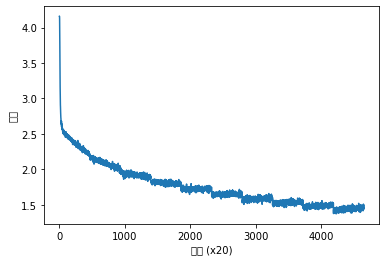

In [11]:
from common import config
# config.GPU = True
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
# from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 학습한 데이터 불러오기

In [3]:
import sys
sys.path.append('../scratch_2')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.72265625
 i: 0.7099609375
 they: 0.62109375
 your: 0.62060546875
 anybody: 0.5888671875

[query] year
 month: 0.85595703125
 week: 0.7626953125
 summer: 0.7373046875
 spring: 0.716796875
 decade: 0.671875

[query] car
 auto: 0.61865234375
 cars: 0.5888671875
 truck: 0.57666015625
 luxury: 0.56982421875
 window: 0.564453125

[query] toyota
 coated: 0.638671875
 nec: 0.62255859375
 seita: 0.62158203125
 engines: 0.6181640625
 honda: 0.6181640625


### 유추문제 풀기

In [5]:
from common.util import analogy

analogy('king','man','queen', word_to_id, id_to_word, word_vecs)
analogy('take','took','go', word_to_id, id_to_word, word_vecs)
analogy('car','cars','child', word_to_id, id_to_word, word_vecs)
analogy('good','better','bad', word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.28515625
 lady: 4.85546875
 a.m: 4.83203125
 gene: 4.796875
 toxin: 4.79296875

[analogy] take:took = go:?
 eurodollars: 4.66796875
 're: 4.59765625
 went: 4.5703125
 came: 4.37109375
 were: 4.3125

[analogy] car:cars = child:?
 a.m: 7.015625
 rape: 5.91796875
 children: 5.078125
 incest: 4.83203125
 feet: 4.765625

[analogy] good:better = bad:?
 more: 6.05859375
 rather: 5.8515625
 less: 5.66796875
 greater: 4.46875
 worse: 3.8203125


### 추가적인 유사도 확인 및 관련 유추문제

In [17]:
# 나라 & 도시

querys = ['seoul', 'paris', 'korea', 'france']

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)
    
analogy(querys[0],querys[1],querys[2], word_to_id, id_to_word, word_vecs)
analogy(querys[2],querys[0],querys[3], word_to_id, id_to_word, word_vecs)


[query] seoul
 taipei: 0.6376953125
 china: 0.61962890625
 brussels: 0.615234375
 india: 0.61083984375
 heightened: 0.60009765625

[query] paris
 frankfurt: 0.64306640625
 stockholm: 0.63037109375
 brussels: 0.6015625
 tokyo: 0.59423828125
 zurich: 0.578125

[query] korea
 carolina: 0.7265625
 africa: 0.68359375
 african: 0.666015625
 south: 0.65087890625
 taiwan: 0.62548828125

[query] france
 italy: 0.7314453125
 finland: 0.63671875
 britain: 0.63623046875
 pakistan: 0.591796875
 canada: 0.5888671875

[analogy] seoul:paris = korea:?
 pricings: 5.0390625
 non-u.s.: 4.05859375
 carolina: 3.9609375
 korean: 3.923828125
 africa: 3.740234375

[analogy] korea:seoul = france:?
 pricings: 5.1640625
 moody: 4.984375
 anticipation: 4.53125
 weisfield: 4.0625
 remic: 4.0625


In [13]:
for i in range(len(querys)):
    print(querys[i%len(querys):],querys[(i+1)%len(querys):],query[i+2%len(querys):])

france rance ance
rance ance nce
ance nce ce
nce france e
